In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ai_trainer import Personal_Trainer
import squat_separation as ss
import sys
import pickle
import os
import random as rnd

sys.path.append('data')

%matplotlib inline

#Step 1: Instantiate our personal trainer and load preprocessed data

In [2]:
pt = Personal_Trainer('NeckY')
pt.load_squats(os.path.join('data/data_sets','170_squats_full.p'))

#Step 2: Extract features 

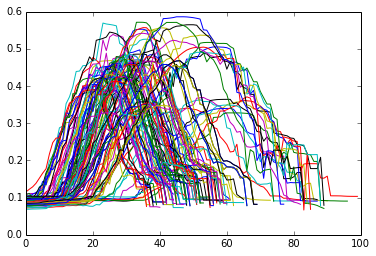

In [3]:
plt.clf()
for squat in pt.get_squats():
    plt.plot(squat[0]['NeckY'])

In [5]:
X, y, adv_features = pt.extract_features()

In [10]:
print X.shape, y.shape, adv_features.keys()

(106, 300) (106,) ['bend_hips_knees', 'back_straight', 'head_aligned_back', 'back_hip_angle', 'feet', 'depth', 'stance_straightness', 'stance_shoulder_width']


In [12]:
len(adv_features['back_straight'])

106

#Step 3: Classification

##Scale features and define testing functions

In [47]:
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import metrics

def predict_labels(X, y, X_test, clf_class, **kwargs):
    clf = clf_class(**kwargs)
    clf.fit(X ,y)
    return clf.predict(X_test)

def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = cross_validation.StratifiedKFold(y, n_folds=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    for i, j in stratified_k_fold:
        X_train, X_test = X[i], X[j]
        y_train = y[i]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[j] = clf.predict(X_test)
    return y_pred

def rnd_prediction(data_dir, clf_class, index=-1, num_iters=10, **kwargs):
    
    #=====[ Instantiate our personal trainer for feature extraction ]=====
    pt_rand = Personal_Trainer('NeckY')
    accuracy = 0

    #=====[ Get all files to use in inference ]=====
    files = os.listdir(data_dir)

    if index < 0 or index > len(files) - 1:
        indices = np.random.randint(len(files),size=num_iters)
    else:
        test_index = index

    print '####################################\n'

    #=====[ Randomly leave out one of the files and test on it num_iter times ]======
    for _ in range(num_iters):
        squats = []

        if index < 0 or index > len(files) - 1:
            test_index = indices[_]
                
        for file_num, f in enumerate(os.listdir(data_dir)):
            if file_num != test_index:
                squats += pickle.load(open(os.path.join(data_dir, f),'rb'))
        
        X, y = pt_rand.extract_features(squats)
        X_test, y_test = pt_rand.extract_features(pickle.load(open(os.path.join(data_dir,files[test_index]),'rb')))
        
        local_accuracy = metrics.accuracy_score(y_test, predict_labels(X, y, X_test, clf_class, **kwargs))
        accuracy += local_accuracy
        
        print(files[test_index], y_test[0], local_accuracy)


    print
    return accuracy/num_iters

##Test Various Classifiers

In [48]:
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, linear_model.LogisticRegression))))
print('Support vector machine(SVM):   {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, svm.SVC))))
print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))

Logistic Regression:           0.98
Support vector machine(SVM):   1.00
Random Forest Classifier:      0.96


##Classify a squat from an individual that has no squats in the training data

In [49]:
print('Logistic Regression:           {:.2f}'.format(rnd_prediction('data/squat_coords', linear_model.LogisticRegression)))
print('Support vector machine(SVM):   {:.2f}'.format(rnd_prediction('data/squat_coords', svm.SVC)))
print('Random Forest Classifier:      {:.2f}'.format(rnd_prediction('data/squat_coords', ensemble.RandomForestClassifier)))

####################################

('squats12.p', 1, 0.20000000000000001)
('squats17.p', 0, 0.72727272727272729)
('squats16.p', 0, 0.80000000000000004)
('squats15.p', 0, 0.59999999999999998)
('squats16.p', 0, 0.80000000000000004)
('squats20.p', 0, 0.55555555555555558)
('squats17.p', 0, 0.72727272727272729)
('squats15.p', 0, 0.59999999999999998)
('squats10.p', 1, 0.22222222222222221)
('squats10.p', 1, 0.22222222222222221)

Logistic Regression:           0.55
####################################

('squats17.p', 0, 1.0)
('squats18.p', 0, 1.0)
('squats16.p', 0, 1.0)
('squats19.p', 0, 1.0)
('squats13.p', 1, 0.0)
('squats14.p', 0, 1.0)
('squats18.p', 0, 1.0)
('squats12.p', 1, 0.0)
('squats19.p', 0, 1.0)
('squats19.p', 0, 1.0)

Support vector machine(SVM):   0.80
####################################

('squats13.p', 1, 0.0)
('squats11.p', 0, 0.88888888888888884)
('squats16.p', 0, 1.0)
('squats15.p', 0, 1.0)
('squats17.p', 0, 1.0)
('squats12.p', 1, 0.0)
('squats14.p', 0, 1.0)
('squats11.p', 